In [1]:
from __future__ import division

import os
import numpy as np
import pandas as pd
import ta
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df = pd.read_csv('DF_SPY.csv', parse_dates=['Date'], index_col=['Date'])

In [3]:
input_size = 5
num_steps = 12
n_epochs = 200

cutoff = int(len(df) * 0.8)
cutoff = int(cutoff / input_size)

In [51]:
seq = df['Return'].values
seq = [np.array(seq[i * input_size: (i + 1) * input_size]) for i in range(len(seq) // input_size)]

y = np.array([seq[i + num_steps] for i in range(len(seq) - num_steps)])
y_train, y_test = y[:cutoff], y[cutoff:]

In [5]:
seq = df['Kalman_Return'].values
seq = [np.array(seq[i * input_size: (i + 1) * input_size]) for i in range(len(seq) // input_size)]

X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)])
x_train, x_test = X[:cutoff], X[cutoff:]

model = Sequential()
model.add(LSTM(256, dropout=0.1, return_sequences=True))
model.add(LSTM(128, dropout=0.1))
model.add(Dense(5))
model.compile(optimizer='RMSprop', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=n_epochs)

Epoch 1/200
870/870 [==============================] - 8s 9ms/step - loss: 2.3463e-04
Epoch 2/200
870/870 [==============================] - 3s 3ms/step - loss: 1.8189e-04
Epoch 3/200
870/870 [==============================] - 3s 3ms/step - loss: 1.7601e-04
Epoch 4/200
870/870 [==============================] - 3s 3ms/step - loss: 1.7613e-04
Epoch 5/200
870/870 [==============================] - 3s 3ms/step - loss: 1.7230e-04
Epoch 6/200
870/870 [==============================] - 3s 3ms/step - loss: 1.7205e-04
Epoch 7/200
870/870 [==============================] - 3s 3ms/step - loss: 1.6986e-04
Epoch 8/200
870/870 [==============================] - 3s 3ms/step - loss: 1.7122e-04
Epoch 9/200
870/870 [==============================] - 3s 3ms/step - loss: 1.6856e-04
Epoch 10/200
870/870 [==============================] - 3s 3ms/step - loss: 1.6951e-04
Epoch 11/200
870/870 [==============================] - 3s 3ms/step - loss: 1.6796e-04
Epoch 12/200
870/870 [==============================

870/870 [==============================] - 3s 3ms/step - loss: 1.5980e-04
Epoch 96/200
870/870 [==============================] - 3s 3ms/step - loss: 1.6195e-04A
Epoch 97/200
870/870 [==============================] - 2s 3ms/step - loss: 1.6092e-04
Epoch 98/200
870/870 [==============================] - 2s 3ms/step - loss: 1.6207e-04
Epoch 99/200
870/870 [==============================] - 2s 3ms/step - loss: 1.6004e-04
Epoch 100/200
870/870 [==============================] - 3s 3ms/step - loss: 1.6046e-04
Epoch 101/200
870/870 [==============================] - 4s 4ms/step - loss: 1.6046e-04
Epoch 102/200
870/870 [==============================] - 4s 4ms/step - loss: 1.6024e-04
Epoch 103/200
870/870 [==============================] - 3s 3ms/step - loss: 1.6126e-04
Epoch 104/200
870/870 [==============================] - 3s 3ms/step - loss: 1.6014e-04
Epoch 105/200
870/870 [==============================] - 3s 3ms/step - loss: 1.6177e-04
Epoch 106/200
870/870 [==========================

870/870 [==============================] - 2s 2ms/step - loss: 1.5816e-04
Epoch 188/200
870/870 [==============================] - 2s 2ms/step - loss: 1.5951e-04
Epoch 189/200
870/870 [==============================] - 3s 3ms/step - loss: 1.5785e-04
Epoch 190/200
870/870 [==============================] - 2s 2ms/step - loss: 1.5900e-04
Epoch 191/200
870/870 [==============================] - 2s 2ms/step - loss: 1.5948e-04
Epoch 192/200
870/870 [==============================] - 2s 2ms/step - loss: 1.5770e-04
Epoch 193/200
870/870 [==============================] - 2s 2ms/step - loss: 1.5809e-04
Epoch 194/200
870/870 [==============================] - 3s 3ms/step - loss: 1.5872e-04A:
Epoch 195/200
870/870 [==============================] - 3s 3ms/step - loss: 1.5839e-04
Epoch 196/200
870/870 [==============================] - 2s 3ms/step - loss: 1.6011e-04
Epoch 197/200
870/870 [==============================] - 3s 3ms/step - loss: 1.5907e-04
Epoch 198/200
870/870 [=====================

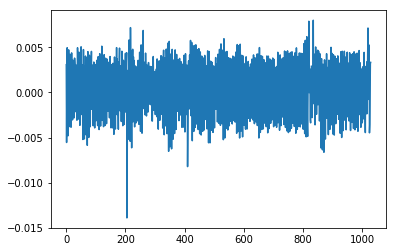

In [6]:
y_hat = model.predict(x_test)
plt.plot(y_hat.flatten())

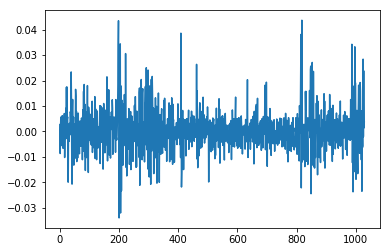

In [7]:
plt.plot(y_hat.flatten() - y_test.flatten())

In [8]:
mean_squared_error(y_hat.flatten(), y_test.flatten())

7.736919689527344e-05

In [40]:
longshort = [100]
for i in range(y_test.shape[0]):
    val = 100
    for ret in y_hat[i]:
        val *= np.exp(ret)
    if val >= 100:  # buy/hold
        for ret in y_test[i]:
            longshort.append(longshort[-1] * np.exp(ret))
    else:
        for ret in y_test[i]:
            longshort.append(longshort[-1] * np.exp(-ret))

Text(0.5,1,'LSTM Portfolio Performance With Kalman Denoising')

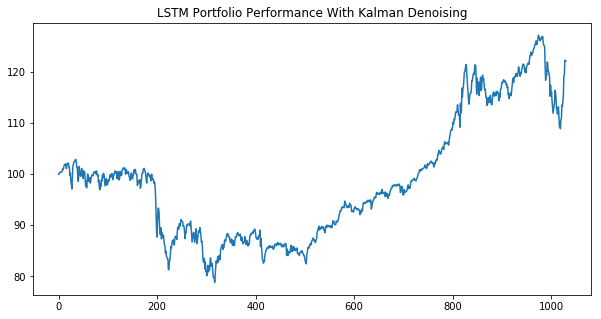

In [41]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(longshort)
ax.set_title('LSTM Portfolio Performance With Kalman Denoising')

In [42]:
longshort = pd.Series(longshort)
returns = longshort.pct_change()

print 'Total Return =', longshort.iloc[-1] / longshort.iloc[0] - 1
print 'Return Mean = ', returns.mean() * 100
print 'Return Stdev = ', returns.std() * 100
print 'Sharpe = ', returns.mean() / returns.std() * 100

Total Return = 0.22175335821383735
Return Mean =  0.0229279001805
Return Stdev =  0.834449308366
Sharpe =  2.74766842643


In [43]:
longonly = [100]
for i in range(y_test.shape[0]):
    val = 100
    for ret in y_hat[i]:
        val *= np.exp(ret)
    if val >= 100:  # buy/hold
        for ret in y_test[i]:
            longonly.append(longonly[-1] * np.exp(ret))
    else:
        for ret in y_test[i]:
            longonly.append(longonly[-1])

Text(0.5,1,'LSTM Portfolio Performance With Kalman Denoising')

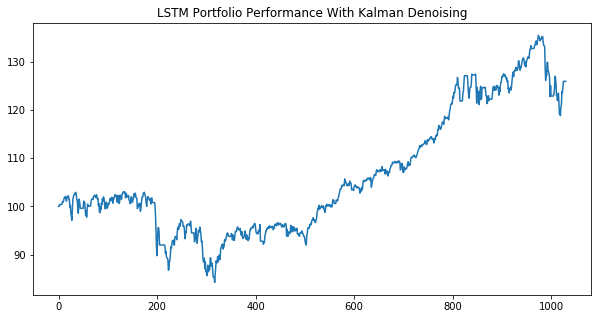

In [44]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(longonly)
ax.set_title('LSTM Portfolio Performance With Kalman Denoising')

In [45]:
longonly = pd.Series(longonly)
returns = longonly.pct_change()

print 'Total Return =', longonly.iloc[-1] / longonly.iloc[0] - 1
print 'Return Mean = ', returns.mean() * 100
print 'Return Stdev = ', returns.std() * 100
print 'Sharpe = ', returns.mean() / returns.std() * 100

Total Return = 0.25936410954330236
Return Mean =  0.0253198669063
Return Stdev =  0.764791891254
Sharpe =  3.31068715502


In [47]:
pd.DataFrame({'Kalman + LSTM': longshort}).to_csv('Kalman.csv', index=False)

In [62]:
mean_squared_error(y_hat.flatten(), y_test.flatten())

7.736919689527344e-05

In [57]:
y_hat_train = model.predict(x_train)

mean_squared_error(y_hat_train.flatten(), y_train.flatten())

0.00016164073164728768

In [63]:
from decimal import Decimal

'%.2E' % Decimal('7.736919689527344e-05')

'7.74E-05'